In [1]:
import numpy as np
import pandas as pd
import find_split as fs
import evaluation as ev
import matplotlib.pyplot as plt

In [2]:
#using the noisy dataset so we can see the effects of pruning
data = np.loadtxt('noisy_dataset.txt')
print(data[:5])

[[-59. -53. -51. -54. -45. -79. -87.   4.]
 [-66. -53. -59. -62. -69. -81. -79.   1.]
 [-41. -57. -63. -40. -73. -66. -65.   2.]
 [-62. -58. -52. -63. -50. -87. -88.   4.]
 [-63. -58. -64. -67. -74. -87. -87.   4.]]


In [3]:
class binarySearchTree:
    def __init__(self, data, depth=0, label = None):
        self.left_child = None
        self.right_child = None
        self.depth = depth+1
        self.label = label
        self.split_value = None
        self.split_router = None
        
        #default value none, 0 for choosing not to prune, 1 for testing during pruning, 2 for permanently pruned
        self.prune=None 
        
        #set future prune value to most common label in data
        self.prune_label=np.argmax(np.bincount([int(i) for i in data[:,-1]]))
        
        if len(np.unique(data[:,-1]))==1: #assuming last column is for labels
            self.label = data[0,-1]
        
        else:
            #not all samples have same label, do a split
            # split router: router from [1,...,6]
            # split_value: router value
            split_router,split_value,temp_data=fs.find_split(data)
            self.split_value=split_value
            self.split_router=split_router
            l_data=temp_data[0]
            r_data=temp_data[1]
             
            #recursively search the tree, branching into 2 
            self.left_child=binarySearchTree(l_data, self.depth)
            self.right_child=binarySearchTree(r_data, self.depth)
        
    def get_max_depth(self):
        #search each branch recursively and get max depth
            max_depth=[self.depth]
            if self.left_child:
                max_depth.append(self.left_child.get_max_depth())
            if self.right_child:
                max_depth.append(self.right_child.get_max_depth())                 
            return max(max_depth)
        
    def predict_one(self,data):
        if self.prune:
            if self.prune>0:
                return np.array([self.prune_label])
        if self.label:
            return np.array([int(self.label)])
        else:
            if data[self.split_router-1]<=self.split_value:
                return self.left_child.predict_one(data)

            else:
                return self.right_child.predict_one(data)  
            
    def prune_1_node(self,current_path=['parent']):
        if self.label:
            return
        
        #prune refers to whether or not we have tested it before
        if self.prune!=None:
            #if this node is already to be tested for pruning, we cannot be searching for any other nodes to prune!
            if self.prune==1:
            
                raise ValueError('tried to prune two nodes')
                
            #else this means we have already pruned or chosen not to prune this branch, return True
            return True
        
        if self.left_child.label and self.right_child.label:
            print('set 1 to prune at path',current_path)
            self.prune=1            
            #set this node for pruning
            return False
        
        else:
            #recursively search for a prunable tree 
            #if False returned, we found a node to prune
            #if True returned, we have pruned all possible nodes
            l_path=current_path+['l']
            l=self.left_child.prune_1_node(current_path=l_path) 
            if l==False:
                return False
            r_path=current_path+['r']
            r=self.right_child.prune_1_node(current_path=r_path)
            if r==False:
                return False
            

            
        return True
    
    def get_f1(self,data):
        pred=self.predict(data[:,:-1]) 
        cm=ev.confusion_matrix(data[:,-1],pred)
        m=ev.avg_recall_precision(cm)
        return ev.f1_score(m[0],m[1])
    
    def set_prune_status(self,pruned=False):
        
        if self.label:
            return
        if self.prune:

            if self.prune==0 or self.prune==2:
                return       
            if pruned==False:
                self.prune=0
                return
            else:
                self.prune=2
                return
        self.left_child.set_prune_status(pruned)
        self.right_child.set_prune_status(pruned)
                
        
    def prune_tree(self,data,print_path=False):
        end=False
        
        val_error=self.get_f1(data)
        while (not end):
            #find node to prune
            end=self.prune_1_node()
            if print_path==True:
                print('current f1:',val_error)
            #validate and get error
            new_f1=self.get_f1(data)
            if print_path==True:            
                print('new f1 score:',new_f1)
            
            #if error is better, prune or else dont prune
            if new_f1>=val_error:
                if print_path==True:                
                    print('pruned 1!')
                self.set_prune_status(pruned=True)
                val_error=new_f1
            else:
                self.set_prune_status(pruned=False)
                if print_path==True:                
                    print('did not prune')
            
        
            
    def predict(self,data):
        
        data=np.squeeze(data)
        if len(data.shape)>1:
            return np.array([self.predict_one(i) for i in data]).flatten()
        else:
            return self.predict_one(data).flatten()
            

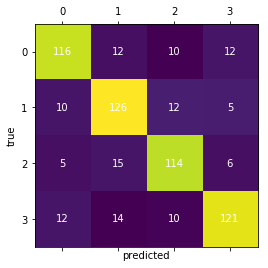

[[116, 10, 5, 12], [12, 126, 15, 14], [10, 12, 114, 10], [12, 5, 6, 121]]
avg recall precision 0.79669488118472 0.79669488118472
avg classification rate 0.795
f1 0.79669488118472


In [4]:
#first, create a train and test set 
#evaluate on the test set to see pre-pruning results

data2=data.copy()
#shuffle data
np.random.shuffle(data2)
split=0.7
train=data2[:int(len(data2)*split)]
test=data2[int(len(data2)*split):]

model=binarySearchTree(train)
y_pred=model.predict(test[:,:-1])
#evaluate
cm=ev.confusion_matrix(test[:,-1],y_pred,plot=True)
print(cm)
r=ev.avg_recall_precision(cm)
print('avg recall precision',r[0],r[1])
print('avg classification rate',ev.avg_classification_rate(cm))
print('f1',ev.f1_score(r[0],r[1]))

In [5]:
#now prune the model
#use print_path=False to not print
model.prune_tree(data2,print_path=True)

set 1 to prune at path ['parent', 'l', 'l', 'l', 'l', 'l', 'r', 'l', 'l', 'l', 'l', 'r', 'r']
current f1: 0.93852058201971
new f1 score: 0.9380351451265061
did not prune
set 1 to prune at path ['parent', 'l', 'l', 'l', 'l', 'l', 'r', 'l', 'l', 'r', 'l', 'l', 'l', 'l']
current f1: 0.93852058201971
new f1 score: 0.9380247498840387
did not prune
set 1 to prune at path ['parent', 'l', 'l', 'l', 'l', 'l', 'r', 'l', 'l', 'r', 'l', 'l', 'l', 'r', 'l']
current f1: 0.93852058201971
new f1 score: 0.9390389821508467
pruned 1!
set 1 to prune at path ['parent', 'l', 'l', 'l', 'l', 'l', 'r', 'l', 'l', 'r', 'l', 'r', 'l', 'l']
current f1: 0.9390389821508467
new f1 score: 0.9390461681238274
pruned 1!
set 1 to prune at path ['parent', 'l', 'l', 'l', 'l', 'l', 'r', 'l', 'l', 'r', 'l', 'r', 'l', 'r', 'r']
current f1: 0.9390461681238274
new f1 score: 0.9385607312306236
did not prune
set 1 to prune at path ['parent', 'l', 'l', 'l', 'l', 'l', 'r', 'l', 'l', 'r', 'l', 'r', 'r', 'l']
current f1: 0.93904616812

new f1 score: 0.9410406593429871
pruned 1!
set 1 to prune at path ['parent', 'r', 'r', 'r', 'r', 'l', 'r', 'r', 'l', 'r', 'r', 'l']
current f1: 0.9410406593429871
new f1 score: 0.9405376412343353
did not prune
set 1 to prune at path ['parent', 'r', 'r', 'r', 'r', 'l', 'r', 'r', 'r', 'l', 'r', 'l']
current f1: 0.9410406593429871
new f1 score: 0.9405396613873819
did not prune
set 1 to prune at path ['parent', 'r', 'r', 'r', 'r', 'l', 'r', 'r', 'r', 'l', 'r', 'r', 'r', 'r']
current f1: 0.9410406593429871
new f1 score: 0.9405396613873819
did not prune
set 1 to prune at path ['parent', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']
current f1: 0.9410406593429871
new f1 score: 0.9420395095873101
pruned 1!
current f1: 0.9420395095873101
new f1 score: 0.9420395095873101
pruned 1!


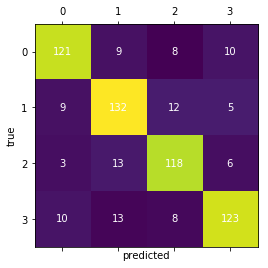

[[121, 9, 3, 10], [9, 132, 13, 13], [8, 12, 118, 8], [10, 5, 6, 123]]
avg recall precision 0.8247397131448378 0.8247397131448378
avg classification rate 0.8233333333333334
f1 0.8247397131448378


In [6]:
#now use the pruned model on the test set again

y_pred=model.predict(test[:,:-1])
#evaluate
cm=ev.confusion_matrix(test[:,-1],y_pred,plot=True)
print(cm)
r=ev.avg_recall_precision(cm)
print('avg recall precision',r[0],r[1])
print('avg classification rate',ev.avg_classification_rate(cm))
print('f1',ev.f1_score(r[0],r[1]))

In [7]:
#as can be seen above, f1 score on validation set improved after pruning! 